In [305]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

In [3]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [18]:
df_2016 = df[(df.YRDATA == 2016)]
df_2016.head()

,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL
3120,Alabama,9609.0,AUTAUGA COUNTY SCHOOL DISTRICT,2016,80867,7447,53842,19578,6797.0,6775.0,NaN,100.0,9.2,66.6,24.2,76672,74185.0,43030.0,18122.0,43843,23941,7622.0,4563.0,2492.0
3121,Alabama,30931.0,BALDWIN COUNTY SCHOOL DISTRICT,2016,338236,23710,145180,169346,49106.0,48902.0,NaN,100.0,7.0,42.9,50.1,299880,281647.0,156502.0,61621.0,164977,97231,8942.0,5332.0,3143.0
3122,Alabama,912.0,BARBOUR COUNTY SCHOOL DISTRICT,2016,10116,2342,5434,2340,1209.0,1202.0,NaN,100.0,23.2,53.7,23.1,10070,9778.0,5079.0,2064.0,4907,3896,10621.0,5380.0,4272.0
3123,Alabama,2842.0,EUFAULA CITY SCHOOL DISTRICT,2016,26182,3558,15900,6724,2844.0,2836.0,NaN,100.0,13.6,60.7,25.7,29843,25477.0,14015.0,5746.0,15302,7901,8851.0,5384.0,2780.0
3124,Alabama,3322.0,BIBB COUNTY SCHOOL DISTRICT,2016,32486,3664,21846,6976,1716.0,1572.0,NaN,100.0,11.3,67.2,21.5,31662,30616.0,17107.0,7057.0,16407,11087,8931.0,4882.0,3337.0


In [19]:
def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [20]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()

YRDATA                                       NAME   ENROLL  \
STATE                                                                      
Alabama 3220    2016              MOBILE COUNTY SCHOOL DISTRICT  57581.0   
        3187    2016        JEFFERSON COUNTY BOARD OF EDUCATION  36092.0   
        3121    2016             BALDWIN COUNTY SCHOOL DISTRICT  30931.0   
Alaska  4567    2016                  ANCHORAGE SCHOOL DISTRICT  48324.0   
        4558    2016  MATANUSKA SUSITNA BOROUGH SCHOOL DISTRICT  18742.0   

              TOTALREV  TFEDREV  TSTREV  TLOCREV   LOCRTAX  LOCRPROP  \
STATE                                                                  
Alabama 3220    564939    78217  310545   176177  120352.0   94632.0   
        3187    344274    33131  199350   111793   86396.0   86355.0   
        3121    338236    23710  145180   169346   49106.0   48902.0   
Alaska  4567    758779    78331  463256   217192       0.0       0.0   
        4558    303215    18467  222607    62141       0.0       0.0   

              PCTTOTAL  PCTFTOT  PCTSTOT  PCTLTOT  TOTALEXP  TCURSPND  \
STATE                                                                   
Alabama 3220     100.0     13.8     55.0     31.2    606882  525674.0   
        3187     100.0      9.6     57.9     32.5    338349  321988.0   
        3121     100.0      7.0     42.9     50.1    299880  281647.0   
Alaska  4567     100.0     10.3     61.1     28.6    800058  696207.0   
        4558     100.0      6.1     73.4     20.5    358757  276704.0   

              TSALWAGE  TEMPBENE  TCURINST  TCURSSVC  PPCSTOT  PPITOTAL  \
STATE                                                                     
Alabama 3220  284363.0  119121.0    276941    203328   9037.0    4796.0   
        3187  184880.0   74169.0    179721    112276   8795.0    4980.0   
        3121  156502.0   61621.0    164977     97231   8942.0    5332.0   
Alaska  4567  367144.0  231279.0    411183    263280  14397.0    8509.0   
        4558  138729.0   78139.0    150590    119298  14763.0    8035.0   

              PPSTOTAL  
STATE                   
Alabama 3220    3531.0  
        3187    3111.0  
        3121    3143.0  
Alaska  4567    5448.0  
        4558    6365.0

In [21]:
# df_2016[df_2016.NAME.str.lower().str.contains('ozark', regex=False)]

In [22]:
map_data = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

In [38]:
map_data.head()

,STATEFP,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,00001,0100001,Fort Rucker School District,00,KG,12,G5420,B,E,233059995,2735224,+31.4097368,-085.7458071,"POLYGON ((-85.86572 31.45470, -85.86543 31.454..."
1,01,00003,0100003,Maxwell AFB School District,00,KG,12,G5420,B,E,8476761,566857,+32.3809438,-086.3637490,"POLYGON ((-86.37655 32.39358, -86.37621 32.393..."
2,01,00005,0100005,Albertville City School District,00,KG,12,G5420,None,E,68731806,258708,+34.2631303,-086.2106600,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
3,01,00006,0100006,Marshall County School District,00,PK,12,G5420,None,E,1267142967,103647100,+34.3739971,-086.3442702,"MULTIPOLYGON (((-86.10870 34.19063, -86.10873 ..."
4,01,00007,0100007,Hoover City School District,00,KG,12,G5420,None,E,121693900,2594832,+33.3769487,-086.8055789,"MULTIPOLYGON (((-86.66393 33.40902, -86.66333 ..."


In [255]:
sd = df_2016.NAME.str.lower()

my_map = {'schs': 'school district',
         'sch': 'school',
         'dist': 'district',
         'dst': 'district',
         'isd': 'school district',
         'community': 'county',
         'comm': 'county',
         'com': 'county',
         'co': 'county',
         'inc': 'corporation',
         'ind': 'independent',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'jt': '',
         'supv': 'supervisory',
         'twp': 'township',
         'cty': 'city',
         'ctl': 'central',
         'elem': 'elementary'}

drop_map = {'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'cusd': '',
            'usd': '',
            'reg': '',
            'voc': '',
            'r': ''}

my_map = {rf'\b{i}\b': word for i, word in my_map.items()}
drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
sd = sd.replace(my_map, regex=True)

#removes r-{0-9} zones - redundant
sd = sd.str.replace("r-[0-9]+", '', regex=True)

#removes {0-9}-{0-9} zones - redundant
# sd = sd.str.replace("[0-9]+\-[0-9]+", '', regex=True)

#some districts ended with a period before zone number
sd = sd.str.replace('.', '', regex=False)

#some districts had sub-zone in parenthesis - redundant
sd = sd.str.replace("\([^()]*\)", '', regex=True)

#some zones were part of 'district': 'district3-5'
#this clips the last number after previous cleanup statements
# sd = sd.str.replace("[0-9]+$", '', regex=True)

#remove standalone zone numbers - redundant
sd = sd.str.replace(" \d+", '', regex=True)

sd = sd.replace(drop_map, regex=True)

sd = sd.str.rstrip()
sd = sd.str.replace("\s+", ' ', regex=True)
sd = sd.sort_values()
sd

87304                                                      
125094                                                admin
125146                                                admin
125154                                                admin
125155                                                admin
125156                                                admin
125157                                                admin
125158                                                admin
125160                                                admin
125161                                                admin
125164                                                admin
125166                                                admin
125167                                                admin
125168                                                admin
125169                                                admin
125170                                                admin
125171                                  

In [282]:
map_sd = map_data.NAME.str.lower()
print(map_sd.tail())
map_sd = map_sd.replace(my_map, regex=True)
map_sd = map_sd.replace(drop_map, regex=True)

map_sd = map_sd.str.rstrip()
map_sd = map_sd.str.replace("\s+", ' ', regex=True)
map_sd = map_sd.sort_values()
map_sd

10891               american samoa department of education
10892                         guam department of education
10893    commonwealth of the northern mariana islands p...
10894                  puerto rico department of education
10895               virgin islands department of education
Name: NAME, dtype: object


3191                                     administration 10
3199                                     administrative 01
3212                                     administrative 03
3218                                     administrative 04
3219                                     administrative 06
3220                                     administrative 07
3221                                     administrative 08
3222                                     administrative 09
3192                                     administrative 11
3193                                     administrative 12
3194                                     administrative 13
3195                                     administrative 14
3196                                     administrative 15
3197                                     administrative 17
3198                                     administrative 19
3200                                     administrative 20
3202                                     administrative 

In [302]:
count = 0
duplicate = 0
not_matched = []
for district in sd:
    tmp = map_sd.str.match(district).any()

    if tmp == 0:
        not_matched.append(district)
    else:
        count += 1

print(count)
print(count / len(sd))

8831
0.6164746945898778


In [15]:
8061
0.5627225130890052

print(len(sd))
print(len(map_sd))
print(len(map_sd) / len(sd))

14325
10896
0.7606282722513089


In [301]:
town = 'adrian'

print("SD")
print('='*10)
print(sd[sd.str.lower().str.contains(town, regex=False)])
print('='*50)
print("MAP_SD")
print('='*10)
print(map_sd[map_sd.str.lower().str.contains(town, regex=False)])
print('='*50)
print('NOT MATCHED FROM SD')
print('='*10)
for i in not_matched:
    if town in i:
        print(i)


SD
340258         adrian
288157         adrian
162821         adrian
179347         adrian
152180    adrian city
Name: NAME, dtype: object
MAP_SD
4125                adrian
4544           adrian -iii
7807             adrian 61
3566           adrian city
8888    adrian independent
Name: NAME, dtype: object
NOT MATCHED FROM SD


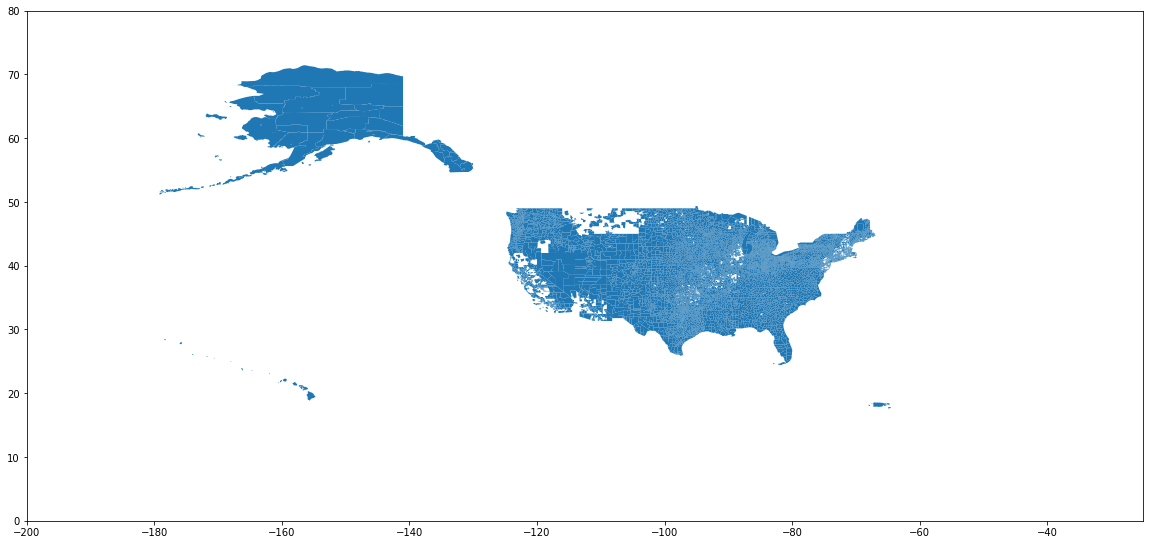

In [319]:
fig = map_data.plot(figsize = (20,20))

plt.xlim([-200,-25])
plt.ylim([0,80])

plt.show()